#Proyecto Machine Learning II
#Detección temprana obstrucciones en *pipelines* de larga distancia mediante la aplicación de algoritmos de machine learning

##Aurores: Marcelo Carmona - Paula Alvarez

In [ ]:
#Carga de Librerias a utilizar
import pandas as pd
import seaborn as sns
import numpy as np
import random
from google.colab import drive
import os
from scipy.optimize import minimize
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer , accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report



In [ ]:
#Montar google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ruta_driver = "/content/drive/MyDrive/Data Science/TALLER DE INVEST. EN DATA/Control"
df_mod = pd.read_excel(ruta_driver + '/Data.xlsx',sheet_name='modelo')
df_real=pd.read_excel(ruta_driver + '/Data.xlsx',sheet_name='real')


#EDA


===== EDA para hoja: modelo =====
Dimensiones: (1519, 5)
Tipos de datos:
 ubicación    float64
elevacion    float64
presion      float64
diametro     float64
espesor      float64
dtype: object
Primeras filas:
    ubicación  elevacion      presion  diametro  espesor
0        0.0    2237.24  6192.164155       7.0     0.25
1      100.0    2230.78  6294.290235       7.0     0.25
2      200.0    2232.78  6229.601188       7.0     0.25
3      300.0    2232.71  6205.728608       7.0     0.25
4      400.0    2233.63  6162.335109       7.0     0.25
Valores nulos por columna:
 ubicación    0
elevacion    0
presion      0
diametro     0
espesor      0
dtype: int64
Valores blancos por columna:
 ubicación    0
elevacion    0
presion      0
diametro     0
espesor      0
dtype: int64
Valores cero por columna:
 ubicación    1
elevacion    0
presion      0
diametro     0
espesor      0
dtype: int64
Estadísticas descriptivas:
            ubicación    elevacion       presion     diametro      espesor
co

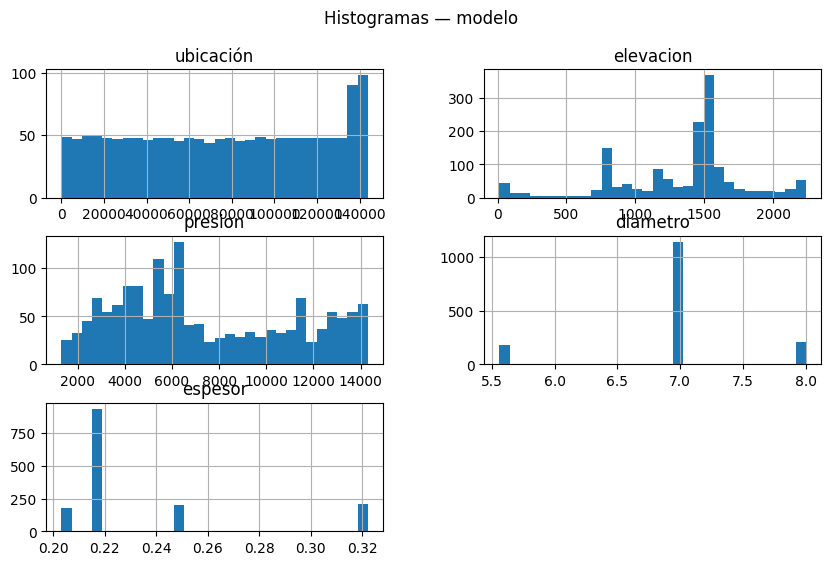

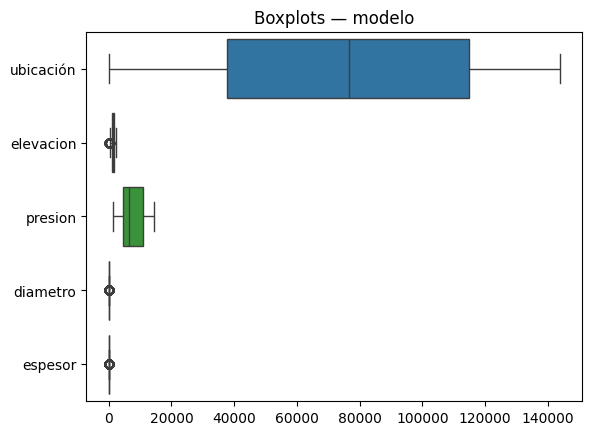


===== EDA para hoja: real =====
Dimensiones: (94814, 12)
Tipos de datos:
 Hora            datetime64[ns]
Km0                    float64
Km30                   float64
Km90                   float64
Km92,5                 float64
Km111                  float64
Km135                  float64
Km137,5                float64
Km143                  float64
Caudal                 float64
Cp                     float64
VelocidadBBa           float64
dtype: object
Primeras filas:
                  Hora          Km0          Km30         Km90       Km92,5  \
0 2025-12-21 08:00:01  6089.020203  11127.501953  4413.558105  4800.682129   
1 2025-12-21 08:00:02  6089.220101  11127.729492  4413.506836  4800.563965   
2 2025-12-21 08:00:03  6089.420419  11127.956055  4413.455078  4800.446289   
3 2025-12-21 08:00:04  6089.620738  11128.865234  4413.403809  4800.328125   
4 2025-12-21 08:00:05  6089.821057  11128.850586  4413.352051  4800.210449   

         Km111        Km135      Km137,5         Km14

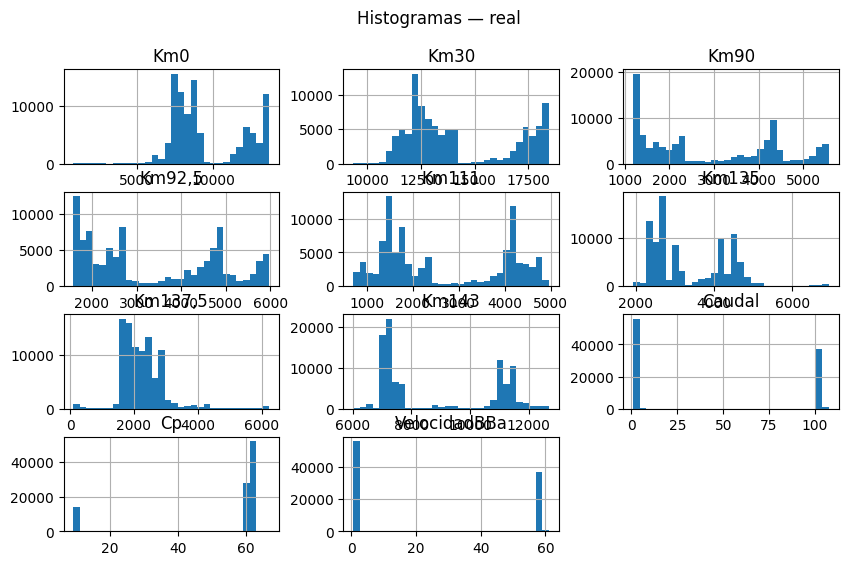

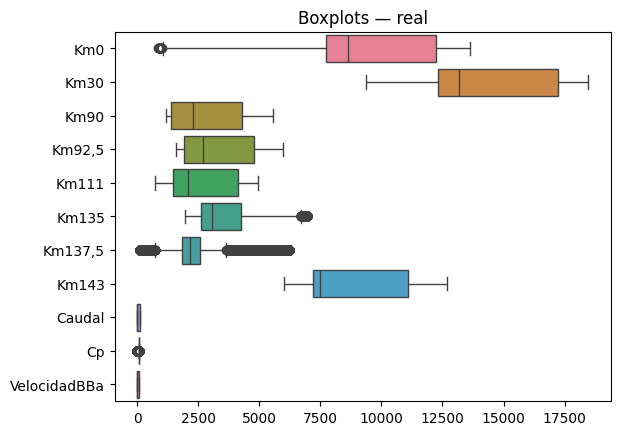

In [ ]:

#APLICACION DE EDA

def run_eda(df, nombre):
    print(f"\n===== EDA para hoja: {nombre} =====")

    # Dimensiones y tipos
    print("Dimensiones:", df.shape)
    print("Tipos de datos:\n", df.dtypes)

    # Primeras filas
    print("Primeras filas:\n", df.head())

    # Valores faltantes
    print("Valores nulos por columna:\n", df.isnull().sum())
    print("Valores blancos por columna:\n", df.apply(lambda x: x.astype(str).str.strip().eq("").sum()))

    # Valores cero (solo numéricos)
    print("Valores cero por columna:\n", (df.select_dtypes(include=[np.number]) == 0).sum())

    # Estadísticas descriptivas
    print("Estadísticas descriptivas:\n", df.describe(include="all"))

    # Outliers con Z-score
    if df.select_dtypes(include=[np.number]).shape[1] > 0:
        z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
        outliers = (z_scores > 3).sum(axis=0)
        print("Outliers detectados (Z-score > 3) por columna:\n", outliers)

    # Visualizaciones rápidas
    df_num = df.select_dtypes(include=[np.number])
    if not df_num.empty:
        df_num.hist(figsize=(10,6), bins=30)
        plt.suptitle(f"Histogramas — {nombre}")
        plt.show()

        sns.boxplot(data=df_num, orient="h")
        plt.title(f"Boxplots — {nombre}")
        plt.show()

# Ejecutar EDA para ambas hojas
run_eda(df_mod, "modelo")
run_eda(df_real, "real")

In [ ]:
df_mod.head()


,ubicación,elevacion,presion,diametro,espesor
0,0.0,2237.24,6192.164155,7.0,0.25
1,100.0,2230.78,6294.290235,7.0,0.25
2,200.0,2232.78,6229.601188,7.0,0.25
3,300.0,2232.71,6205.728608,7.0,0.25
4,400.0,2233.63,6162.335109,7.0,0.25


In [ ]:
df_real.head()

,Hora,Km0,Km30,Km90,"Km92,5",Km111,Km135,"Km137,5",Km143,Caudal,Cp,VelocidadBBa
0,2025-12-21 08:00:01,6089.020203,11127.501953,4413.558105,4800.682129,4501.913086,4084.534180,2343.498291,11044.217773,102.047008,61.737312,57.984943
1,2025-12-21 08:00:02,6089.220101,11127.729492,4413.506836,4800.563965,4501.823242,4083.884277,2341.911377,11042.979492,102.043759,61.737598,57.983097
2,2025-12-21 08:00:03,6089.420419,11127.956055,4413.455078,4800.446289,4501.733398,4083.234619,2341.047852,11041.150391,102.040509,61.737888,57.981255
3,2025-12-21 08:00:04,6089.620738,11128.865234,4413.403809,4800.328125,4501.643555,4082.584717,2340.353027,11038.396484,102.037266,61.738178,57.979408
4,2025-12-21 08:00:05,6089.821057,11128.850586,4413.352051,4800.210449,4501.553223,4082.370850,2339.658447,11040.203125,102.034017,61.738464,57.977562


# CASOS DE GENERACION ALEATORIA DE OBSTRUCCION EN PIPELINE

# Uso del Método de las Características (MOC) para Modelos Transitorios
## Transporte de Sólidos en Tuberías de Larga Distancia

El **método de las características (MOC)** es una técnica matemática robusta utilizada para resolver ecuaciones diferenciales parciales (PDE) hiperbólicas. En el contexto de transporte de sólidos, es fundamental para modelar cómo se propagan las ondas de presión y los perfiles de concentración de pulpa a lo largo de grandes distancias.

---

### ¿Por qué se usa este método?
Las ecuaciones de transporte (masa y momento) en tuberías son de naturaleza hiperbólica. Esto significa que la información (como un cambio en la concentración) se propaga a una velocidad finita a lo largo de líneas específicas en el plano espacio-tiempo $(x, t)$, llamadas **líneas características**.

Al transformar el problema, en lugar de resolver la ecuación en todo el dominio continuo, seguimos la evolución de las variables a lo largo de estas líneas, lo que simplifica significativamente el cálculo numérico.

---

## 1. Aplicación al Transporte de Sólidos

En una tubería, el transporte de una pulpa mineral se describe mediante leyes de conservación. El modelo más simple se basa en la ecuación de continuidad para la concentración de sólidos:

### Ecuación de Continuidad
$$\frac{\partial C}{\partial t} + v \frac{\partial C}{\partial x} = 0$$



**Donde:**
* $C$: Concentración de sólidos.
* $v$: Velocidad del flujo.
* $x$: Posición longitudinal en la tubería.
* $t$: Tiempo.

Esta es una ecuación hiperbólica de primer orden que representa un fenómeno de advección pura.

---

## 2. Método de las Características Paso a Paso

### Paso 1: Identificar la Curva Característica
Para la ecuación de advección anterior, la trayectoria de la información en el plano $(x, t)$ se define por la relación:
$$\frac{dx}{dt} = v$$
Esto implica que la señal de concentración se desplaza exactamente a la velocidad del fluido.

### Paso 2: Transformar la PDE en ODE
Al movernos "encima" de la línea característica, la derivada parcial se transforma en una derivada total respecto al tiempo:
$$\frac{dC}{dt} = 0$$
Esto convierte una ecuación diferencial parcial compleja en una **Ecuación Diferencial Ordinaria (ODE)** mucho más simple.

### Paso 3: Interpretación Física
El resultado $\frac{dC}{dt} = 0$ indica que la concentración inicial en un punto dado se transporta **sin cambios** a lo largo de la tubería, siempre que sigamos la trayectoria de la velocidad del flujo.

---

## 3. Sistemas de Alta Complejidad

En sistemas reales (como mineroductos), el modelo debe considerar variables adicionales que acoplan las ecuaciones de masa y momento:

* **Flujo no uniforme:** Variaciones de velocidad en el tiempo y espacio (transitorios hidráulicos).
* **Interacción Sólido-Líquido:** Efectos de deslizamiento (*slip velocity*) entre fases.
* **Gradientes de Presión:** Pérdidas por fricción (Darcy-Weisbach) y cambios de cota topográfica.



Incluso en estos casos, la estrategia del MOC permanece igual:
1.  Definir las **curvas características** del sistema (generalmente $C^+$, $C^-$ y la línea de corriente).
2.  Resolver las **ODEs** resultantes sobre dichas curvas para predecir fenómenos como el **golpe de ariete** o el desplazamiento de baches de diferente densidad.

---

In [ ]:
#===============================================
#CODIGO INCLUYENDO LA CALIBRACION DEL MODELO MOC
#METODO DE LAS CARACTERISTICAS
#===============================================

# ==========================================
# 1. PARÁMETROS FÍSICOS Y CARGA DE DATOS
# ==========================================
rho = 2010          # kg/m3
g = 9.81
D = 7 * 0.0254      # m
A = np.pi * (D**2) / 4
dx = 100.0          # m

# Estado inicial y elevaciones
#df_mod['H_ini'] = (df_mod['presion'] * 0.703 / 2.01) + df_mod['elevacion']
# Fórmula general: H = (P_kPa * 1000) / (rho * g) + elevacion df_mod['H_ini'] = (df_mod['presion'] * 1000) / (rho * g) + df_mod['elevacion']
df_mod['H_ini'] = (df_mod['presion'] * 1000) / (rho * g) + df_mod['elevacion']
H_steady = df_mod['H_ini'].values
elevaciones = df_mod['elevacion'].values
caudal_inicial_real = df_real['Caudal'].values

# ==========================================
# 2. MOTOR MOC (FUNCION CORE)
# ==========================================
def run_moc(seconds, q_series, a, f, km_obs=None, severidad=1.0):
    dt = dx / a
    steps = int(seconds / dt)
    nodes = len(H_steady)

    H_curr = np.copy(H_steady)
    Q_curr = np.ones(nodes) * (q_series[0] / 3600)

    B = a / (g * A)
    R = (f * dx) / (2 * g * D * A**2)
    nodo_obs = int(km_obs * 1000 / dx) if km_obs is not None else -1

    # Matriz para guardar resultados (solo guardamos presiones cada 1s para comparar)
    history_P_kpa = np.zeros((steps, nodes))

    for t in range(steps):
        H_prev, Q_prev = np.copy(H_curr), np.copy(Q_curr)

        # C.C. Entrada
        Q_curr[0] = q_series[min(t, len(q_series)-1)] / 3600
        H_curr[0] = (H_prev[1] - B*Q_prev[1] + R*Q_prev[1]*abs(Q_prev[1])) + B*Q_curr[0]

        # Nodos Internos
        for i in range(1, nodes - 1):
            R_local = R * severidad if i == nodo_obs else R
            Cp = H_prev[i-1] + B*Q_prev[i-1] - R_local*Q_prev[i-1]*abs(Q_prev[i-1])
            Cm = H_prev[i+1] - B*Q_prev[i+1] + R_local*Q_prev[i+1]*abs(Q_prev[i+1])
            H_curr[i] = (Cp + Cm) / 2
            Q_curr[i] = (Cp - Cm) / (2 * B)

        # C.C. Salida
        H_curr[-1] = H_steady[-1]

        # Guardar Presión en kPa para facilitar comparación y ML
        history_P_kpa[t, :] = (H_curr - elevaciones) * rho * g / 1000

    return history_P_kpa, dt

# ==========================================
# 3. CALIBRACIÓN DE PARÁMETROS (a, f)
# ==========================================
def objetivo_calibracion(params):
    a_try, f_try = params
    # Simulamos el caso base (sin obstrucción)
    P_sim, _ = run_moc(200, caudal_inicial_real, a_try, f_try)

    indices = {'Km0': 0 , 'Km30': 300, 'Km90': 900,'Km92,5': 925, 'Km111': 1110, 'Km135': 1350, 'Km137,5': 1375,'Km143': 1430}
    mse_total = 0
    for nombre, idx in indices.items():
        p_real = df_real[nombre].values[:len(P_sim)]
        mse_total += mean_squared_error(p_real, P_sim[:, idx])
    return mse_total / len(indices)

print("Calibrando modelo MOC con datos reales...")
res = minimize(objetivo_calibracion, x0=[1050, 0.018], bounds=[(900, 1200), (0.01, 0.05)], method='L-BFGS-B')
a_opt, f_opt = res.x
print(f"Parámetros Óptimos -> Celeridad: {a_opt:.2f} m/s, Fricción: {f_opt:.4f}")

# ===================================================
# 4. GENERACIÓN DE 10 SIMULACIONES (BASE DE DATOS ML)
# ===================================================


def generar_dataset_final(n_sims, ratio_no_obs=0.5):
    sensores = {'Km0': 0 ,'Km30': 300, 'Km90': 900, 'Km92,5': 925,
                'Km111': 1110, 'Km135': 1350, 'Km137,5': 1375, 'Km143': 1430}
    final_df_list = []

    n_no_obs = int(n_sims * ratio_no_obs)
    n_obs = n_sims - n_no_obs

    for n in range(n_no_obs):
        km_obs = None
        sev = 1.0
        print(f"Simulación obs_{n}: Obstrucción en Km {km_obs}, Severidad={sev:.2f}")
        P_mat, delta_t = run_moc(600, caudal_inicial_real, a_opt, f_opt, km_obs, sev)
        step_1s = int(1.0 / delta_t)
        for t_idx in range(0, len(P_mat), step_1s):
            row = {'sim_id': f"no_obs_{n}", 'timestamp': round(t_idx * delta_t, 2),
                   'Obstruccion_Km': -1.0, 'Target': 0, 'Severidad':sev}
            for nombre, idx in sensores.items():
                row[nombre] = P_mat[t_idx, idx]
            final_df_list.append(row)

    for n in range(n_obs):
        km_obs = round(random.uniform(5, 130), 1)
        sev = random.uniform(2, 5)
        print(f"Simulación obs_{n}: Obstrucción en Km {km_obs}, Severidad={sev:.2f}")
        P_mat, delta_t = run_moc(600, caudal_inicial_real, a_opt, f_opt, km_obs, sev)
        step_1s = int(1.0 / delta_t)
        for t_idx in range(0, len(P_mat), step_1s):
            row = {'sim_id': f"obs_{n}", 'timestamp': round(t_idx * delta_t, 2),
                   'Obstruccion_Km': km_obs, 'Target': 1,'Severidad':sev}
            for nombre, idx in sensores.items():
                row[nombre] = P_mat[t_idx, idx]
            final_df_list.append(row)

    return pd.DataFrame(final_df_list)


dataset_ml = generar_dataset_final(20)

# ==========================================
# 5.GUARDADO DE ARCHIVO FORMATO CSV
# ==========================================

nombre_archivo = 'dataset_entrenamiento_obstrucciones.csv'
ruta_final = os.path.join(ruta_driver, nombre_archivo)

dataset_ml.to_csv(ruta_final, index=False)

print("\n--- PROCESO FINALIZADO ---")
print(f"✅ Archivo guardado exitosamente en Google Drive: {ruta_final}")

print(f"Dataset generado con {dataset_ml['sim_id'].nunique()} simulaciones.")
print(f"Columnas disponibles: {dataset_ml.columns.tolist()}")
print(dataset_ml.sample(5)) # Mostrar 5 filas aleatorias


Calibrando modelo MOC con datos reales...
Parámetros Óptimos -> Celeridad: 907.50 m/s, Fricción: 0.0203
Simulación obs_0: Obstrucción en Km None, Severidad=1.00
Simulación obs_1: Obstrucción en Km None, Severidad=1.00
Simulación obs_2: Obstrucción en Km None, Severidad=1.00
Simulación obs_3: Obstrucción en Km None, Severidad=1.00
Simulación obs_4: Obstrucción en Km None, Severidad=1.00
Simulación obs_5: Obstrucción en Km None, Severidad=1.00
Simulación obs_6: Obstrucción en Km None, Severidad=1.00
Simulación obs_7: Obstrucción en Km None, Severidad=1.00
Simulación obs_8: Obstrucción en Km None, Severidad=1.00
Simulación obs_9: Obstrucción en Km None, Severidad=1.00
Simulación obs_0: Obstrucción en Km 106.6, Severidad=3.45
Simulación obs_1: Obstrucción en Km 87.5, Severidad=4.62
Simulación obs_2: Obstrucción en Km 83.1, Severidad=2.02
Simulación obs_3: Obstrucción en Km 114.6, Severidad=4.22
Simulación obs_4: Obstrucción en Km 98.2, Severidad=4.04
Simulación obs_5: Obstrucción en Km 24.

#Analisis de dataset sintetico simulado

In [ ]:
# Cargar el dataset generado en el paso anterior
df = pd.read_csv(os.path.join(ruta_driver, 'dataset_entrenamiento_obstrucciones.csv'))


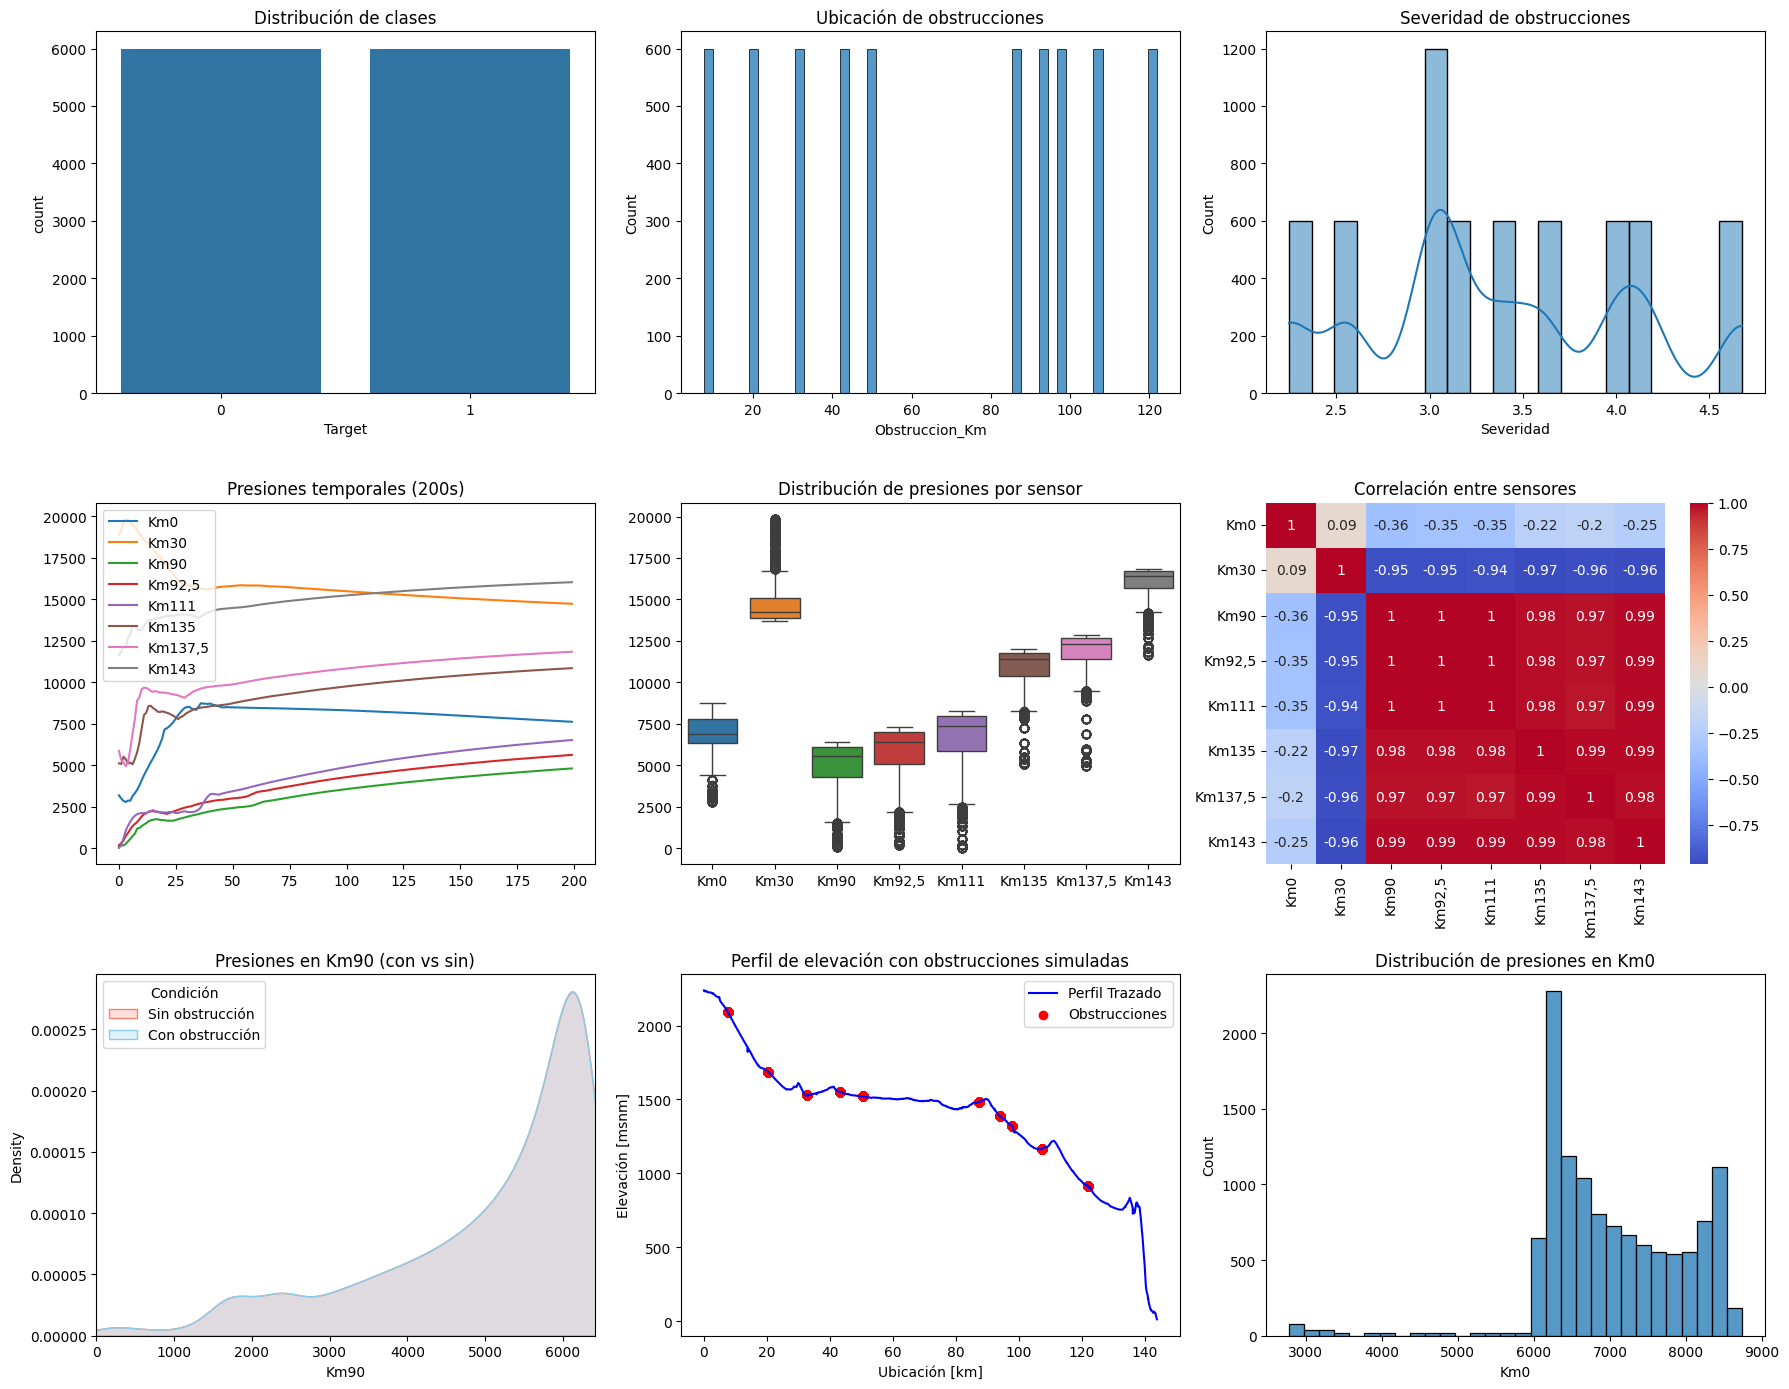

In [ ]:

#======================================
#VISUALIZACION DE DATASET SINTETICO
#======================================
df['Target'] = df['Target'].astype(int)

# Crear layout con subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

# 1. Distribución de clases
sns.countplot(x="Target", data=df, ax=axes[0])
axes[0].set_title("Distribución de clases")

# 2. Ubicación de obstrucciones
sns.histplot(df[df["Target"]==1]["Obstruccion_Km"], bins=50, kde=False, ax=axes[1])
axes[1].set_title("Ubicación de obstrucciones")

# 3. Severidad de obstrucciones
if "Severidad" in df.columns:
    sns.histplot(df[df["Target"]==1]["Severidad"], bins=20, kde=True, ax=axes[2])
    axes[2].set_title("Severidad de obstrucciones")
else:
    axes[2].text(0.5,0.5,"No hay columna Severidad", ha="center")
    axes[2].set_title("Severidad de obstrucciones")

# 4. Evolución temporal de presiones (primeros 200s)
sensores = ["Km0","Km30","Km90","Km92,5","Km111","Km135","Km137,5","Km143"]
for sensor in sensores:
    axes[3].plot(df["timestamp"][:200], df[sensor][:200], label=sensor)
axes[3].set_title("Presiones temporales (200s)")
axes[3].legend()

# 5. Boxplot de presiones por sensor
sns.boxplot(data=df[sensores], ax=axes[4])
axes[4].set_title("Distribución de presiones por sensor")

# 6. Correlación entre sensores
sns.heatmap(df[sensores].corr(), annot=True, cmap="coolwarm", ax=axes[5])
axes[5].set_title("Correlación entre sensores")

# 7. Diferencias en Km90 (con vs sin obstrucción)
sns.kdeplot(
    data=df,
    x="Km90",
    hue="Target",
    fill=True,
    ax=axes[6],
    palette={0: "skyblue", 1: "salmon"}
)
axes[6].set_title("Presiones en Km90 (con vs sin)")
axes[6].set_xlim(0, df["Km90"].max())
axes[6].legend(title="Condición", labels=["Sin obstrucción", "Con obstrucción"])

# 8. Perfil de elevación con obstrucciones
if df_mod is not None:
    # Convertir ubicación a km
    eje_x_km = df_mod["ubicación"] / 1000
    axes[7].plot(eje_x_km, df_mod["elevacion"], c="blue", label="Perfil Trazado")

    # Obstrucciones ya están en km, no multiplicar
    obs_points = df[df["Target"]==1]["Obstruccion_Km"]
    elev_points = [
        df_mod.loc[df_mod["ubicación"].sub(p*1000).abs().idxmin(),"elevacion"] for p in obs_points
    ]
    axes[7].scatter(obs_points, elev_points, c="red", label="Obstrucciones")

    axes[7].set_title("Perfil de elevación con obstrucciones simuladas")
    axes[7].set_xlabel("Ubicación [km]")   # <-- eje X en km
    axes[7].set_ylabel("Elevación [msnm]")
    axes[7].legend()

else:
    axes[7].text(0.5,0.5,"No se pudo cargar modelo", ha="center")
    axes[7].set_title("Perfil de elevación con obstrucciones")

# 9. Distribución de presiones en Km0
sns.histplot(df["Km0"], bins=30, ax=axes[8])
axes[8].set_title("Distribución de presiones en Km0")

plt.tight_layout()
plt.show()

#Entrenamiento  Baseline

                Modelo  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression  0.638611   0.677076  0.530000  0.594578  0.644276
1                  SVM  0.512222   0.518395  0.344444  0.413885  0.534086
2        Random Forest  0.920833   0.991564  0.848889  0.914696  0.990737
3              XGBoost  0.771667   0.797084  0.728889  0.761463  0.871973


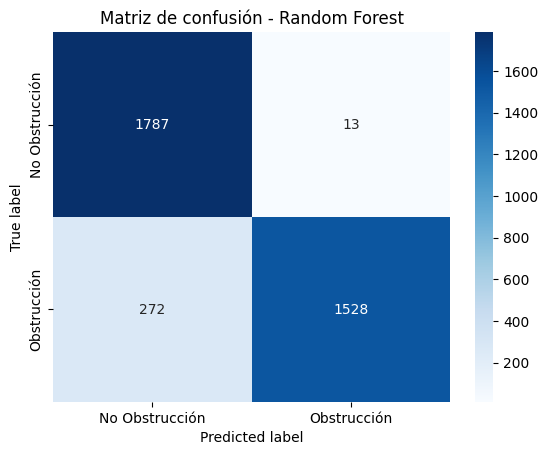

In [ ]:

# ==============================
# 1. Features y target
# ==============================
# Mantener solo sensores físicos
features = ["Km0","Km30","Km90","Km92,5","Km111","Km135","Km137,5","Km143"]
X = df[features]
y = df["Target"]

# ==============================
# 2. Train/Test split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ==============================
# 3. Definir modelos con Pipeline
# ==============================
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(probability=True, random_state=42))
])

rf = RandomForestClassifier(random_state=42)

xgb_clf = xgb.XGBClassifier(eval_metric="logloss", random_state=42)

# ==============================
# 4. Entrenar y evaluar
# ==============================
modelos = {
    "Logistic Regression": log_reg,
    "SVM": svm_clf,
    "Random Forest": rf,
    "XGBoost": xgb_clf
}

resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:,1] if hasattr(modelo, "predict_proba") else modelo.decision_function(X_test)

    resultados.append({
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })

resultados_df = pd.DataFrame(resultados)
print(resultados_df)

# ==============================
# 5. Matriz de confusión ejemplo
# ==============================
cm = confusion_matrix(y_test, rf.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Obstrucción","Obstrucción"],
            yticklabels=["No Obstrucción","Obstrucción"])
plt.title("Matriz de confusión - Random Forest")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


In [ ]:
#============================================================================
#BUSQUEDA AJUSTE DE HIPERPARAMETROS UTILIZANDO RANDOM SEACRH CROSS VALIDATION
#============================================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# ==============================
# Random Forest
# ==============================
param_rf = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

rf = RandomForestClassifier(random_state=42)
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_rf,
    n_iter=20,
    cv=cv,
    scoring="f1",
    random_state=42,
    n_jobs=-1
)
random_search_rf.fit(X, y)
print("Mejores parámetros RF:", random_search_rf.best_params_)
print("Mejor score RF:", random_search_rf.best_score_)

# ==============================
# XGBoost
# ==============================
param_xgb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.5]
}

xgb_clf = xgb.XGBClassifier(eval_metric="logloss", random_state=42)
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_xgb,
    n_iter=20,
    cv=cv,
    scoring="f1",
    random_state=42,
    n_jobs=-1
)
random_search_xgb.fit(X, y)
print("Mejores parámetros XGB:", random_search_xgb.best_params_)
print("Mejor score XGB:", random_search_xgb.best_score_)

# ==============================
# Regresion Logistica
# ==============================

# Pipeline: escalado + regresión logística
logit_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga'))
])

# Espacio de hiperparámetros
param_logit = {
    "clf__C": np.logspace(-3, 2, 10),   # fuerza de regularización
    "clf__penalty": ["l1", "l2", "elasticnet"],
    "clf__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0]  # solo usado si penalty='elasticnet'
}

random_search_logit = RandomizedSearchCV(
    estimator=logit_pipe,
    param_distributions=param_logit,
    n_iter=20,
    cv=cv,
    scoring="f1",
    random_state=42,
    n_jobs=-1
)

random_search_logit.fit(X, y)

print("Mejores parámetros Logit:", random_search_logit.best_params_)
print("Mejor score Logit:", random_search_logit.best_score_)



# ==============================
# SVM
# ==============================

# Pipeline: escalado + SVM
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(class_weight='balanced', probability=True, random_state=42))
])

# Espacio de hiperparámetros
param_svm = {
    "clf__C": [0.1, 1, 10, 100],
    "clf__kernel": ["linear", "rbf", "poly"],
    "clf__gamma": ["scale", "auto"]
}

random_search_svm = RandomizedSearchCV(
    estimator=svm_pipe,
    param_distributions=param_svm,
    n_iter=20,
    cv=cv,
    scoring="f1",
    random_state=42,
    n_jobs=-1
)

random_search_svm.fit(X, y)

print("Mejores parámetros SVM:", random_search_svm.best_params_)
print("Mejor score SVM:", random_search_svm.best_score_)



Mejores parámetros RF: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Mejor score RF: 0.9264440555053461
Mejores parámetros XGB: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}
Mejor score XGB: 0.7828482644486785


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Mejores parámetros Logit: {'clf__penalty': 'l1', 'clf__l1_ratio': 0.25, 'clf__C': np.float64(0.5994842503189409)}
Mejor score Logit: 0.5960345795741259
Mejores parámetros SVM: {'clf__kernel': 'rbf', 'clf__gamma': 'auto', 'clf__C': 100}
Mejor score SVM: 0.8400410834501315


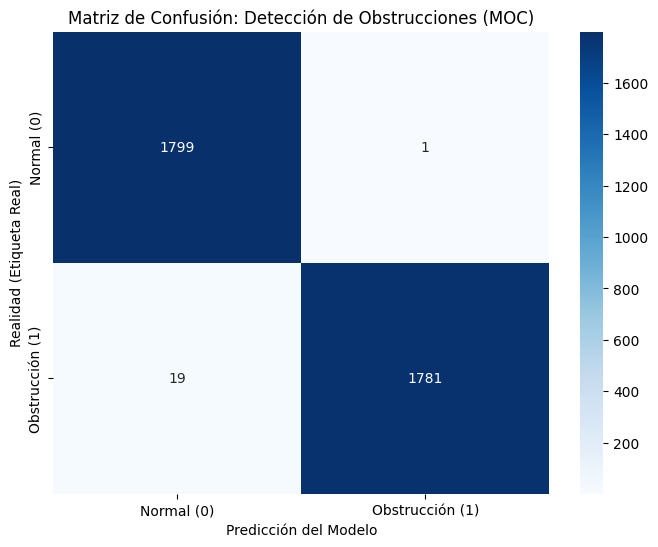

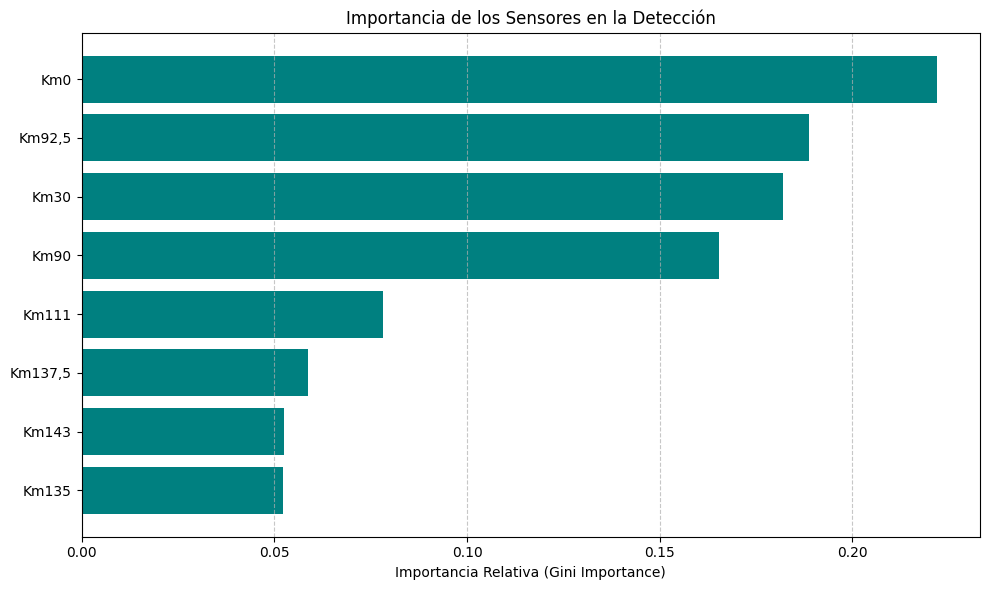


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1800
           1       1.00      0.99      0.99      1800

    accuracy                           0.99      3600
   macro avg       0.99      0.99      0.99      3600
weighted avg       0.99      0.99      0.99      3600



In [ ]:
#======================================
#VALIDANDO METRICAS DE RANDOM FOREST
#MODELO SELECCIONADO
#======================================


# ==========================================
# 1. MATRIZ DE CONFUSIÓN
# ==========================================
# Usamos el mejor modelo encontrado (best_rf) para predecir sobre el set de prueba
# y_pred = best_rf.predict(X_test)
y_pred = random_search_rf.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal (0)', 'Obstrucción (1)'],
            yticklabels=['Normal (0)', 'Obstrucción (1)'])

plt.title('Matriz de Confusión: Detección de Obstrucciones (MOC)')
plt.xlabel('Predicción del Modelo')
plt.ylabel('Realidad (Etiqueta Real)')
plt.show()



# ==========================================
# 2. IMPORTANCIA DE CARACTERÍSTICAS
# ==========================================
# importances = best_rf.feature_importances_
importances = random_search_rf.best_estimator_.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Importancia de los Sensores en la Detección')
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importancia Relativa (Gini Importance)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



# ==========================================
# 3. REPORTE DE MÉTRICAS ADICIONALES
# ==========================================
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred))

In [ ]:
#===============================================
#REVISON DE STABILIDAD DEL MODELO SELECCIONADO
#uso de k fold estratificado
#===============================================
# ==============================
# Configuración del modelo con hiperparámetros óptimos
# ==============================
rf_best = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    random_state=42,
    n_jobs=-1
)

# ==============================
# Definir K-Fold estratificado
# ==============================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==============================
# Definir métricas de evaluación
# ==============================
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# ==============================
# Validación cruzada
# ==============================
results = cross_validate(
    rf_best,
    X, y,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# ==============================
# Reporte de resultados
# ==============================
print("Resultados de validación cruzada (5-Fold Estratificado):")
for metric in scoring.keys():
    print(f"{metric.capitalize()} promedio: {np.mean(results['test_' + metric]):.4f} "
          f"(± {np.std(results['test_' + metric]):.4f})")


Resultados de validación cruzada (5-Fold Estratificado):
Accuracy promedio: 0.9313 (± 0.0060)
Precision promedio: 0.9956 (± 0.0028)
Recall promedio: 0.8663 (± 0.0107)
F1 promedio: 0.9264 (± 0.0068)
